# Detecting Deepfake Images

#### Brad Shook, Drew Dibble, Daniel Cowan, and Chris Freel

##### December 16, 2020

## Intro

Before diving into our research, it is important to understand the issue of deepfakes and why this research is necessary. So, what are deepfakes? Deepfakes are artificial images or videos created with deep learning. Most deepfakes are created through generative adversarial networks (GANs). A GAN network consists of a generator and a discriminator that work against each other to create and tune a fake image or video. In the training process, the generator attempts to fool the discriminator into believing the content is real while the discriminator attempts to identify fake content. In the end, a highly trained GAN can create a seemingly real video of someone by using only a single image. Deepfakes can be weaponized to damage political relations, voting behavior, companies, etc. For example, a deepfake video could be used to portray a president making false and threatening claims towards another country or a group of people. With the popularity of social media and online news, a deepfake video can travel rapidly through society. Andrea Hickerson, the Director of the School of Journalism and Mass Communications at the University of South Carolina, remarks that, “If we take \[deepfakes\] as truth or evidence, we can easily make false conclusions with potentially disastrous consequences.” It is these “disastrous consequences” that create the need for research in the detection of deepfakes so that governments, news outlets, and social media companies can effectively spot deepfakes and stop them in their tracks.


Thus, our goal was to create neural network models that were able to accurately identify deepfake images. All relevant code can be seen in nnCode.py. We start by importing the Python file:

In [ ]:
from nnCode import *

## Data

To solve our problem of identifying deep fake images, we used two datasets found on Kaggle. Both datasets had images of both real and fake faces, with their corresponding labels. The first dataset (Photoshop dataset) was the smaller of the two, with 960 fake faces and 1081 real faces. The fake faces in this dataset were created by expert photoshop users. The fake faces were subjectively broken down into difficulty levels of easy, mid, and hard. While the easy fakes are easily detectable by the human eye, the mid-level fakes are difficult to detect, and the hard-level fakes are nearly impossible to detect with the naked eye.

![](small.png)

The second dataset (GAN dataset) was much larger, with 70k fake faces and 70k real faces. In this dataset, the fake faces were created using GANs as previously described. Many of these GAN-generated fake faces are quite difficult to detect with the naked eye. 

![](example.png)

For our exploratory data analysis, we looked through the images to identify patterns in the fake faces such as crossed eyes, changes in skin color, blurry lips, etc. We didn’t need to produce any plots or charts because we found the split of real and fake faces by examining the Kaggle datasets. 

## Data Preprocessing

Next, we needed to pre-process our images. We determined that color would be necessary after viewing some of the fake images had to do with slight color differences such as differences in eye color. Thus, we used a color mode of RGB so that each image had three filters. Then, we resized the images to 256 by 256 after noticing that the 128 by 128 images were blurry. After making these decisions, we used an image data generator to augment our existing images. We made use of a rescale, rotation, zoom, shear, and a horizontal flip in order to augment our existing data set and supply our model with even more images for training. It is important to note that an image data generator applies its data augmentation on each batch during training.

In [ ]:
training_batch_generator_140k, validation_batch_generator_140k, testing_batch_generator_140k = create_datagens_for_140k();
training_batch_generator_small, validation_batch_generator_small, testing_batch_generator_small = create_datagens_for_small();

After creating the image data generators, we extract the inputs (features) and the outputs (labels) from the the testing batch generators. These inputs and outputs are used later when analyzing the performance of our model.

In [3]:
features140kTest, labels140kTest = process_testing_data_140k(testing_batch_generator_140k)
featuresSmallTest, labelsSmallTest = process_testing_data_small(testing_batch_generator_small)

## Creating the Models

### Architecture

The first neural network that we created was a simple model in terms of complexity. This model used pairs of convolutional layers and max pooling layers. Convolutional layers are typically used to extract features of images. Max pooling layers, on the other hand, are used to extract only the most relevant features from an image. This reduces the number of activations that are passed through the rest of the network, helping to reduce the likelihood of the model being overfit. These pairs of layers build the base of the model and then their final output is flattened into a one-dimensional vector. This large vector is connected to pairs of dense layers and dropout layers. The number of these pairs were optimized (see Hyperparameter Tuning). A dropout layer is used to reduce overfitting by forcing the neural network to train with less information. The last part of the simple model was a single node which classified the input as fake (0) or real (1). 

The second model made use of transfer learning. Transfer learning uses a pre-made model that has already been trained for a certain task. These models are highly optimized and allow for performance improvements over scratch-made models that have had limited training. The pre-made model that we chose as a foundation for our transfer model was the Xception model. We chose this model because it had been previously used to detect deepfakes and showed strong results (Ranjan et al.). The Xception model was used as the base of our neural network. Similar to the simple model, we added pairs of dense and dropout layers after flattening the output of the Xception model. 

### $\;\;\;\;\;\;\;\;\;$ Simple Model   $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$  Transfer Model

In [7]:
from IPython.display import HTML, display
display(HTML("<table><tr><td><img src='final_simple.png'style=margin:80px;></td><td><img src='transfer.png' style=margin:80px;></td></tr></table>"))

,


In [5]:
simple_model_140k = create_simple_model()

In [6]:
simple_model_small = create_simple_model()

In [7]:
t_model_140k, xcept_model_140k = create_transfer_model_for_140k()

In [8]:
t_model_small, xcept_model_small = create_transfer_model_for_small()

### Hyperparameter Tuning
The structure of our models determined the hyperparameters available for us to tune. After deciding on the models’ structures, we further decided that we would manually tune each hyperparameter that could be tuned: learning rates, number of dense layer neurons, dropout layer probabilities, convolutional layer filters, kernel size, pool size (for max pooling layers), epochs of training, and batch size. Each parameter was tuned individually and manually; to tune, we changed one parameter at a time, trained the model, and observed the resulting change in the model’s accuracy. The parameter setting with the highest accuracy (and no indication of overfitting) was maintained, and the next parameter was tuned. 

After tuning all parameters, we determined that the most important hyperparameters to the simple model’s performance were the learning rate (which we determined must be very low) and the number of dense layer neurons (we found that fewer neurons gave better performance). We also found ideal performance when setting the number of convolutional layer filters to 64 for the first convolutional layer and doubling for the next two layers, meaning the third layer would have the same number of filters as the size of the input photos (256). For the transfer model, the most important hyperparameters were the number of dense layer neurons (we found that starting with 256, the size of a dimension of an input photo, was ideal, along with halving the number of nodes for each successive dense layer) and the dropout probabilities (0.3 was ideal; forgetting too much was obviously detrimental to model performance, but forgetting too little caused overfitting).

For the transfer model in particular, we implemented training fine-tuning, as mentioned in the paper by Ranjan et al., which is a process in which Xception model layers are trainable for a certain amount of training runs and untrainable for the rest of training (i.e. freezing the transfer model after a certain number of epochs). We found through brute force testing that the ideal split was 3 epochs before freezing and two epochs afterward. This split ensured the Xception layers could become accustomed to our problem space while avoiding overfitting to our training data. Luckily, our model structures (dropout layers, no overly complex architectures, etc) made it so that overfitting was never too much of an issue, but aforementioned dropout layer decisions and training epoch limitations further helped us avoid overfitting.

NOTE: Hyperparameter tuning was only done on the models designed to fit the GAN-generated data, not those trained on the Photoshop dataset. We wanted to test models with the same structures on different datasets.

## Training

In [ ]:
simple_model_140k_post_fit = fit_simple_model(simple_model_140k, training_batch_generator_140k, validation_batch_generator_140k)

In [ ]:
simple_model_small_post_fit = fit_simple_model(simple_model_small, training_batch_generator_small, validation_batch_generator_small)

In [ ]:
transfer_model_140k_post_fit = fit_transfer_model_140k(t_model_140k, xcept_model_140k, training_batch_generator_140k, validation_batch_generator_140k)

In [ ]:
transfer_model_small_post_fit = fit_transfer_model_small(t_model_small, xcept_model_small, training_batch_generator_small, validation_batch_generator_small)

**Note:** Due to the amount of time that it takes to train our models, we decided to save them after training and load the trained models as a time-saving measure.

In [4]:
simple_model_140k, simple_model_small, t_model_140k, t_model_small = load_models()

## Experiments

Our first experiment attempted to compare the performance of our simple model and the transfer model when using the GAN dataset. The second experiment focused on the same comparison but this time when using the Photoshop dataset. Lastly, we performed a third experiment, this experiment's goal was to compare how the performance of the models compared when using the two datasets. In this experiment, we set out to determine if one dataset was more easily classifed over the other. 

## Results

In determining between real and fake facial images, we consider our network successful if it is consistently able to successfully identify a face as real or fake that we are unable to distinguish with the human eye. Our goal with the network is to be able to aid in cutting down on disinformation online, such as by finding fake profile pictures or fake pictures of famous people.
Along with feeding images into the network that we had trouble distinguishing, the main metrics we used to analyze the success of the network were accuracy, precision, and recall. Accuracy measures the percentage of images the network was able to correctly identify as real or fake in a test over many images. Precision measures what proportion of the images the network the identified as real were actually real, and recall compares the proportion of images the network correctly identified as real with the total number of real images in the network. We found that the transfer model performed better in all three metrics: accuracy, precision, and recall.

### Experiment 1

**SIMPLE MODEL - GAN Dataset**

In [13]:
evaluate_model(simple_model_140k, features140kTest, labels140kTest)


Test Data Accuracy:
0.6599038461538461

Recall Score
0.7419480772984579

Precision Score
0.6318151595744681


**TRANSFER MODEL - GAN Dataset**

In [15]:
evaluate_model(t_model_140k, features140kTest, labels140kTest)


Test Data Accuracy:
0.9754807692307692

Recall Score
0.9668163185633418

Precision Score
0.9831282254863041


After gathering the metrics for the testing data, we used the features in the test set to get a set of predictions. Using these predictions, we formed the data that we use in the ROC curves.

In [ ]:
simple_model_140k_fpr, t_model_140k_fpr, simple_model_140k_tpr, t_model_140k_tpr = get_roc_data(simple_model_140k, t_model_140k, features140kTest, labels140kTest)

**Note:** Due to the amount of memory resources that it takes to gather the ROC data, we decided to save this data after calculating it and load the data here as a memory-saving measure.

In [2]:
simple_model_140k_fpr = load_ROC_data("simple_model_140k_fpr")
simple_model_140k_tpr = load_ROC_data("simple_model_140k_tpr")
t_model_140k_fpr = load_ROC_data("t_model_140k_fpr")
t_model_140k_tpr = load_ROC_data("t_model_140k_tpr")

Using the ROC data, we are able to create an ROC curve plot to compare the performances of the simple model and transfer model.

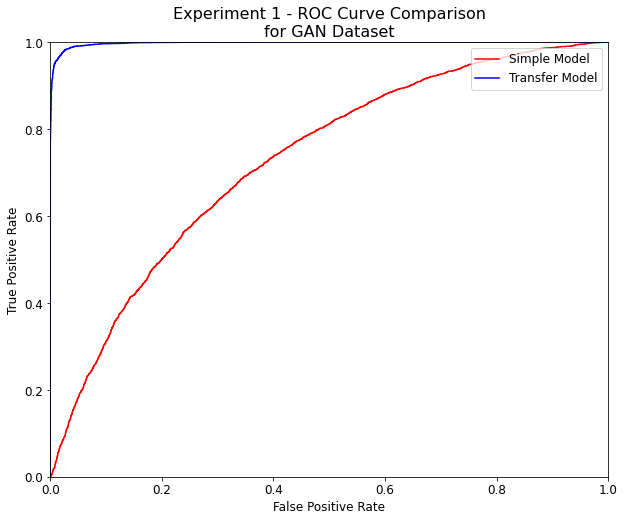

In [4]:
plot_roc_curve_comparison_exp_1(simple_model_140k_fpr, t_model_140k_fpr, simple_model_140k_tpr, t_model_140k_tpr)

It is clear from the scores and the ROC curves that the transfer model outperformed the simple model for the GAN dataset. First, the transfer model achieved 97.5% accuracy with 96.7% recall and 98.3% precision on the test set while the simple model only achieved a measly 66% accuracy with 74.2% recall and 63.2% precision. Secondly, the ROC curves show that the transfer model outperformed the simple model for the GAN dataset. An ROC curve is a graph that plots a model's performance at all classification thresholds. Specifically, an ROC curve plots true positive rate vs. false positive rate. The ROC curves above show that the transfer model drastically outperformed the simple model at all classification thresholds.

### Experiment 2

**SIMPLE MODEL - Photoshop Dataset**

In [12]:
evaluate_model(simple_model_small, featuresSmallTest, labelsSmallTest)


Test Data Accuracy:
0.5463414634146342

Recall Score
0.8073394495412844

Precision Score
0.55


**TRANSFER MODEL - Photoshop Dataset**

In [13]:
evaluate_model(t_model_small, featuresSmallTest, labelsSmallTest)


Test Data Accuracy:
0.5073170731707317

Recall Score
0.944954128440367

Precision Score
0.5202020202020202


Using the test set, we gather the ROC data.

In [ ]:
simple_model_small_fpr, t_model_small_fpr, simple_model_small_tpr, t_model_small_tpr = get_roc_data(simple_model_small, t_model_small, featuresSmallTest, labelsSmallTest)

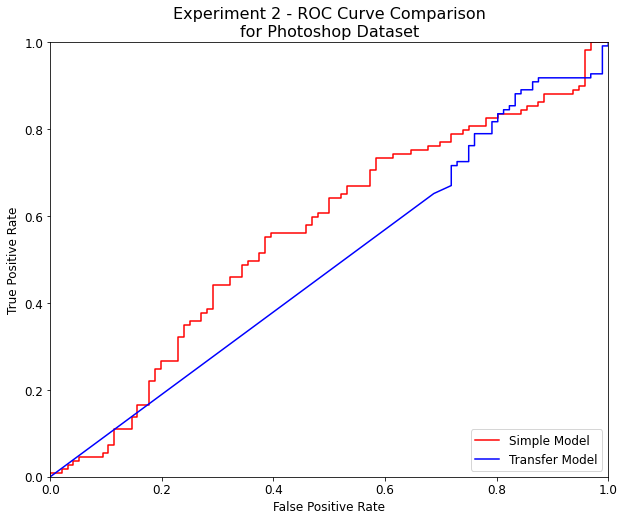

In [7]:
plot_roc_curve_comparison_exp_2(simple_model_small_fpr, t_model_small_fpr, simple_model_small_tpr, t_model_small_tpr)

The most obvious result here is that the two models performed significantly worse on the Photoshop dataset. This could be due to the fact there was much less Photoshop data on which the models could train. With the GAN data, there were 140,000 images while there were only about 2,000 images with the Photoshop data. With that being said, the simple model outperformed the transfer model on the Photoshop data in both accuracy and precision, while the transfer model achieved a higher recall score. The ROC curve shows that the simple model outperforms the transfer model at most classification thresholds. Overall, the simple model seems to be the preferable model for the Photoshop data, but both performed rather poorly.

### Experiment 3

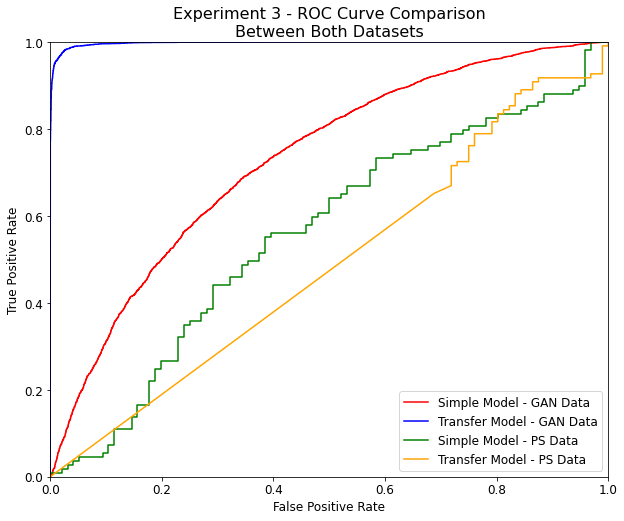

In [10]:
plot_roc_curve_comparison_exp_3(simple_model_140k_fpr, t_model_140k_fpr, simple_model_small_fpr, t_model_small_fpr, simple_model_140k_tpr, t_model_140k_tpr, simple_model_small_tpr, t_model_small_tpr)

From this plot, we can directly observe that both models performed better on the GAN data. Thus, it appears the GAN dataset is more easily classified. Again, this could be due to the fact that there were about 138,000 more GAN images than Photoshop images. With many more images, the two models are able to observe more patterns in the data and make more informed classifications. 

## Conclusion

From our experiments, we can make two conclusions: both models perform better on the GAN dataset, and the transfer model performs remarkably better on the GAN data than the simple model. Both conclusions were at least somewhat expected. 

As for the first conclusion, we largely built and fine-tuned our models to be able to identify real and fake GAN-generated images. That is to say, all hyperparameter tuning was performed on models by fitting them to the GAN data rather than the Photoshop data, as having our model identify GAN-generated deepfakes was the original task. Also, as mentioned previously, there was a large discrepancy in the size of the two datasets, which certainly might account for some of the differences in model performances. We conclude that the discrepancy in the models' performances on the two datasets speaks to the significant differences in the ways the two datasets are generated. Of course the primary difference is that one is generated using a neural network, and the other is generated by human Photoshop experts, but what we also realized is that clearly, the tactics used to generate the two datasets are vastly different. Therefore, networks optimized to identify GAN deepfakes look for features and characteristics of images that may not exist in Photoshopped images.

As for the second conclusion, the Xception model with Imagenet weights is already pretrained for image categorization tasks, and with our task being a categorization of real and fake images, we expected the transfer model to accurately distinguish between the two categories for the GAN data. Furthermore, we figured it would take a relatively deep network to be able to properly extract enough features from the images to distinguish between real and fake. The simple model simply is not deep enough to perform the necessary feature extraction. We are, however, impressed that such a simple model was able to distinguish between real and fake GAN-generated images with almost 70% accuracy, and this fact indicates to us that while transfer learning may be necessary to achieve greater than 95% accuracy, a simple model can still perform quite admirably on relatively hard data.

## Resources

1. https://www.kaggle.com/ciplab/real-and-fake-face-detection
    - This was the smaller dataset in which the fake images were created with Photoshop.
2. https://www.kaggle.com/xhlulu/140k-real-and-fake-faces
    - This was the larger dataset in which the fake images were created with GANs.
3. https://www.popularmechanics.com/technology/security/a28691128/deepfake-technology/
    - We used this resource for the discussion of deepfakes in our introduction. 
4. https://keras.io/api/metrics/classification_metrics/#truenegatives-class
    - We used this resource for a guide on precision and recall. 
5. P. Ranjan, S. Patil and F. Kazi, "Improved Generalizability of Deep-Fakes Detection using Transfer Learning Based CNN Framework," 2020 3rd International Conference on Information and Computer Technologies (ICICT), San Jose, CA, USA, 2020, pp. 86-90, doi: 10.1109/ICICT50521.2020.00021.
     - This report supported our decision to implement a transfer learning model to solve our problem. 
6. https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc#:~:text=An%20ROC%20curve%20
    - This resource helped us write about our ROC curves.